In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from medmnist import BloodMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

!nvidia-smi

Thu Nov 21 19:17:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   47C    P8    17W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = BloodMNIST(
    split='train', 
    download=True, 
    transform=train_transform, 
    size=128
)
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)

val_dataset = BloodMNIST(
    split='val',
    download=True,
    transform=val_transform,
    size=128
)
val_loader = DataLoader(val_dataset, batch_size=100)

Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz


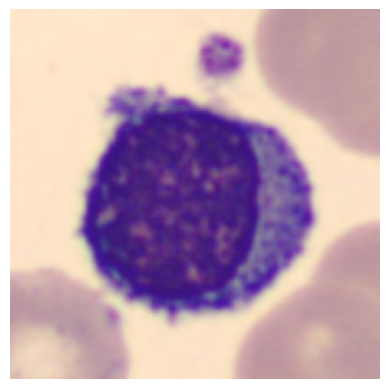

In [6]:
img, _ = next(iter(val_loader))

img = img[0].squeeze().permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device).view(-1)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = outputs.max(1)[1]
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [8]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device).view(-1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            pred = outputs.max(1)[1]
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(dataloader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=True)
for param in model.parameters():
    param.require_grad = False

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [48]:
def pretrained_resnet_feature(model, dataloader, device):
    model = model.to(device)
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Extracting features...'):
            images = images.to(device)
            labels = labels.view(-1)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            all_outputs.append(probs.cpu())
            all_labels.append(labels)
    
    features = torch.cat(all_outputs, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    return features, labels

train_features, train_labels = pretrained_resnet_feature(model, train_loader, device)
print("Extracted train features shape:", train_features.shape)
val_features, val_labels = pretrained_resnet_feature(model, val_loader, device)
print("Extracted validate features shape:", val_features.shape)

Extracting features...: 100%|██████████| 374/374 [00:42<00:00,  8.73it/s]


Extracted train features shape: torch.Size([11959, 1000])


Extracting features...: 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]

Extracted validate features shape: torch.Size([1712, 1000])


In [65]:
"""
Annotation available
"""
# pre-trained classifier with KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_labels)

val_preds = knn.predict(val_features.numpy())
val_acc = accuracy_score(val_labels, val_preds)
print(f"Pretrained Classifier with KNN - Val Acc: {val_acc * 100.:.2f}%")

# pre-trained classifier with logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)

val_preds = clf.predict(val_features.numpy())
val_acc = accuracy_score(val_labels, val_preds)
print(f"Pretrained Classifier with LR - Val Acc: {val_acc * 100.:.2f}%")

Pretrained Classifier with KNN - Val Acc: 53.56%
Pretrained Classifier with LR - Val Acc: 58.94%


In [66]:
"""
Annotation unavailable
"""
# pre-trained classifier with K-means
kmeans = KMeans(n_clusters=8, random_state=0)
km_labels = kmeans.fit_predict(val_features.numpy())

def cluster_acc(true_labels, cluster_labels):
    cm = confusion_matrix(true_labels, cluster_labels)
    
    # apply hungarian algorithm for unsupervised mapping
    row_ind, col_ind = linear_sum_assignment(-cm)

    total_correct = cm[row_ind, col_ind].sum()
    acc = total_correct / len(true_labels)
    mapping = {cluster: label for cluster, label in zip(col_ind, row_ind)}
    
    return acc, mapping

acc, mapping = cluster_acc(val_labels, km_labels)
print(f"Pretrained Classifier with K-means Clustering - Val Acc: {acc * 100.:.2f}%")
print(f"K-means Cluster to True Label Mapping:", mapping)

/h/lkcai/anaconda3/envs/video_comp_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pretrained Classifier with K-means Clustering - Val Acc: 27.51%
K-means Cluster to True Label Mapping: {3: 0, 4: 1, 2: 2, 6: 3, 7: 4, 5: 5, 1: 6, 0: 7}


In [10]:
num_classes = 8
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)

In [11]:
# pre-trained classifier with random head
val_loss, val_acc = validate(model, val_loader, criterion, device)
print(f"Pretrained Classifier with RaVal Loss:   {val_loss:.4f} Val Acc: {val_acc:.2f}% ")

Pretrained Classifier with RaVal Loss:   2.2946 Val Acc: 9.52% 


In [3]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | " + \
          f"Val Loss:   {val_loss:.4f} Val Acc: {val_acc:.2f}% ")

In [20]:
import clip
from PIL import Image


bloodmnist_label = {
    "0": "basophil",
    "1": "eosinophil",
    "2": "erythroblast",
    "3": "immature granulocytes(myelocytes, metamyelocytes and promyelocytes)",
    "4": "lymphocyte",
    "5": "monocyte",
    "6": "neutrophil",
    "7": "platelet",
}


model, preprocess = clip.load("RN50", device=device)
texts = clip.tokenize(["a photo of " + v for v in bloodmnist_label.values()]).to(device)

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device).view(-1)
            
        logits_per_image, logits_per_text = model(images, texts)
        probs = logits_per_image.softmax(dim=-1).max(1)[1]
        
        correct += probs.eq(labels).sum().item()
        total += labels.size(0)

accuracy = 100. * correct / total
print(accuracy)

# image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
# text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

# with torch.no_grad():
#     image_features = model.encode_image(image)
#     text_features = model.encode_text(text)
    
#     logits_per_image, logits_per_text = model(image, text)
#     probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# print("Label probs:", probs)

100%|██████████| 18/18 [00:06<00:00,  2.68it/s]

25.64252336448598
